In [72]:
from matplotlib import pyplot as plt
from sympy import OperationNotSupported


def visualize_results_performance(results):
    # Bar chart for classifier performance
    plt.figure(figsize=(10, 6))
    plt.bar(results.keys(), results.values(), color='skyblue')
    plt.xlabel('Classifier', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title(f'Classifiers Accuracy for {file_name}', fontsize=16)
    plt.xticks(rotation=45)
    plt.ylim(0, 100) # 0-100% accuracy

    # Calculate and plot the average accuracy
    avg_accuracy = sum(results.values()) / len(results)
    plt.axhline(y=avg_accuracy, color='r', linestyle='--', label=f'Avg Accuracy: {avg_accuracy:.4f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [73]:
from sklearn.utils.validation import check_array
from sklearn.preprocessing import LabelBinarizer

def adjust_predicted_probabilities(y_pred, n_classes):
    """
    Ensure predicted probabilities have probabilities for all classes.
    """
    n_samples, n_pred_classes = y_pred.shape
    if n_pred_classes < n_classes:
        adjusted_pred = np.zeros((n_samples, n_classes))
        adjusted_pred[:, :n_pred_classes] = y_pred
        return adjusted_pred
    return y_pred

In [74]:
def validate(y_true, y_pred):
    # Validate shapes
    print(f"Shape of y_true: {y_true.shape}")
    print(f"Shape of y_pred: {y_pred.shape}")
    
    print(f"Number of classes in y_true: {len(np.unique(y_true))}")
    print(f"Number of classes in y_pred: {len(np.unique(y_pred))}")
    
    print(f"Predicted classes: {y_pred.shape[1]}")
    print(f"Number of unique classes: {len(le.classes_)}")
    

In [75]:
"""
Data analysis inspired by following article: https://www.kaggle.com/code/priyanshusethi/classification-model-comparison-diseases

In this article the author considered the target to be a 'Outcome variable' which is a binary variable.

However I am using the 'Disease' as the target variable which is a multi-class variable. I expect this to change 
(maybe significantly), the performance results.
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from pathlib import Path

# Import functions from the analysis package
file_name = "Disease Symptoms and Patient Profile Dataset_exported"
dataset_path = Path(f"./kaggle/{file_name}.csv")
dataset = pd.read_csv(dataset_path)

features = dataset.iloc[:, 1:]
target = dataset.iloc[:, 0]
print(f"Features to be use for prediction:\n{features.head()}")
print(f"Target variable:\n{target.head()}")

x_train,x_test,y_train,y_test = train_test_split(features, target, test_size=0.2, random_state=42)

oe = OrdinalEncoder(categories=[['No','Yes']])
x_train_fever = oe.fit_transform(x_train["Fever"].array.reshape(-1, 1))
x_test_fever = oe.transform(x_test["Fever"].array.reshape(-1, 1))

be = OrdinalEncoder(categories=[['No','Yes']])
x_train_cough = be.fit_transform(x_train["Cough"].array.reshape(-1, 1))
x_test_cough = be.transform(x_test["Cough"].array.reshape(-1, 1))

ce = OrdinalEncoder(categories=[['No','Yes']])
x_train_fat = ce.fit_transform(x_train["Fatigue"].array.reshape(-1, 1))
x_test_fat = ce.transform(x_test["Fatigue"].array.reshape(-1, 1))

de = OrdinalEncoder(categories=[['No','Yes']])
x_train_breath = de.fit_transform(x_train["Difficulty Breathing"].array.reshape(-1, 1))
x_test_breath = de.transform(x_test["Difficulty Breathing"].array.reshape(-1, 1))

fe = OrdinalEncoder(categories=[['Low','Normal',"High"]])
x_train_blood = fe.fit_transform(x_train["Blood Pressure"].array.reshape(-1, 1))
x_test_blood = fe.transform(x_test["Blood Pressure"].array.reshape(-1, 1))

ge = OrdinalEncoder(categories=[['Low','Normal',"High"]])
x_train_chol = ge.fit_transform(x_train["Cholesterol Level"].array.reshape(-1, 1))
x_test_chol = ge.transform(x_test["Cholesterol Level"].array.reshape(-1, 1))

gender_ohe = OneHotEncoder(drop='first')
x_train_gender = gender_ohe.fit_transform(x_train['Gender'].array.reshape(-1, 1)).toarray() # The OneHotEncoder produces a sparse matrix, which may not concatenate directly with NumPy arrays (e.g., x_train_fever, x_train_cough). Sparse matrix stores only non-zero values to optimize space (CSR)
x_test_gender = gender_ohe.transform(x_test['Gender'].array.reshape(-1, 1)).toarray()

outcome_ohe = OneHotEncoder(drop='first')
x_train_outcome = outcome_ohe.fit_transform(x_train['Outcome Variable'].array.reshape(-1, 1)).toarray()
x_test_outcome = outcome_ohe.fit_transform(x_test['Outcome Variable'].array.reshape(-1, 1)).toarray()

x_train_transformed = np.concatenate((x_train_fever,x_train_cough,x_train_fat,x_train_breath,x_train_blood,x_train_chol,x_train_gender, x_train_outcome),axis=1)

x_test_transformed = np.concatenate((x_test_fever,x_test_cough,x_test_fat,x_test_breath,x_test_blood,x_test_chol,x_test_gender, x_test_outcome),axis=1)

# Multi-class encoding for target variable, since it is a multi-class variable
le = LabelEncoder()
le.fit(list(y_train) + list(y_test))

y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

# Validation of classes throughout the encoding process
print(f"Classes in y_train_encoded: {np.unique(y_train_encoded)}")
print(f"Classes in y_test_encoded: {np.unique(y_test_encoded)}")
print(f"Classes in LabelEncoder: {len(le.classes_)}")


Features to be use for prediction:
  Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
0   Yes    No     Yes                  Yes   19  Female            Low   
1    No   Yes     Yes                   No   25  Female         Normal   
2    No   Yes     Yes                   No   25  Female         Normal   
3   Yes   Yes      No                  Yes   25    Male         Normal   
4   Yes   Yes      No                  Yes   25    Male         Normal   

  Cholesterol Level Outcome Variable  
0            Normal         Positive  
1            Normal         Negative  
2            Normal         Negative  
3            Normal         Positive  
4            Normal         Positive  
Target variable:
0      Influenza
1    Common Cold
2         Eczema
3         Asthma
4         Asthma
Name: Disease, dtype: object
Classes in y_train_encoded: [  0   1   2   3   4   5   6   7   8   9  13  14  15  16  17  18  19  20
  21  24  25  26  27  28  29  30  31  32  33  34  35  

In [95]:
def train_and_test_sklearn_classifier():
     # Train the model
    clf.fit(x_train_transformed, y_train_encoded)
    
    # Ensure pred contains probabilities
    if hasattr(clf, "predict_proba"):
        pred_proba = clf.predict_proba(x_test_transformed)
        validate(y_test_encoded, pred_proba)
        pred_proba = adjust_predicted_probabilities(pred_proba, len(le.classes_))  # Adjust probabilities
    else:
        raise OperationNotSupported(f"Classifier {name} does not support probability predictions")
    
    loss = log_loss(
        y_true=y_test_encoded, 
        y_pred=pred_proba, 
        labels=np.arange(len(le.classes_))
    )
    return loss

def train_and_test_xgboost():
    """
    TODO fix mapping for this
    Train and evaluate an XGBoost classifier with consistent class handling.
    """
    # Encode target with continuous integer labels
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    
    # Train the classifier
    clf.fit(x_train, y_train_encoded)
    
    # Predict probabilities
    y_pred = clf.predict_proba(x_test)
    
    # Align predictions to the full set of classes
    num_classes = len(le.classes_)
    y_pred_aligned = np.zeros((y_pred.shape[0], num_classes))
    for i, cls in enumerate(le.classes_):
        if cls in le.classes_:
            y_pred_aligned[:, i] = y_pred[:, np.where(le.classes_ == cls)[0][0]]
    
    # Calculate log loss
    loss = log_loss(y_test_encoded, y_pred_aligned)
    return loss

    


Training and testing Naive Bayes:
Shape of y_true: (70,)
Shape of y_pred: (70, 102)
Number of classes in y_true: 44
Number of classes in y_pred: 1139
Predicted classes: 102
Number of unique classes: 116
Loss: 29.2384

Training and testing K-Neighbors:
Shape of y_true: (70,)
Shape of y_pred: (70, 102)
Number of classes in y_true: 44
Number of classes in y_pred: 5
Predicted classes: 102
Number of unique classes: 116
Loss: 30.0834

Training and testing Random Forest:
Shape of y_true: (70,)
Shape of y_pred: (70, 102)
Number of classes in y_true: 44
Number of classes in y_pred: 138
Predicted classes: 102
Number of unique classes: 116
Loss: 29.1238

Training and testing XGBoost:
Error: y contains previously unseen labels: 'Tonsillitis'

Training and testing MLP Classifier:
Shape of y_true: (70,)
Shape of y_pred: (70, 102)
Number of classes in y_true: 44
Number of classes in y_pred: 4692
Predicted classes: 102
Number of unique classes: 102
Loss: 9.2703


/Users/patrikholler/workspace/Multiple-Disease-Prediction-Bot/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


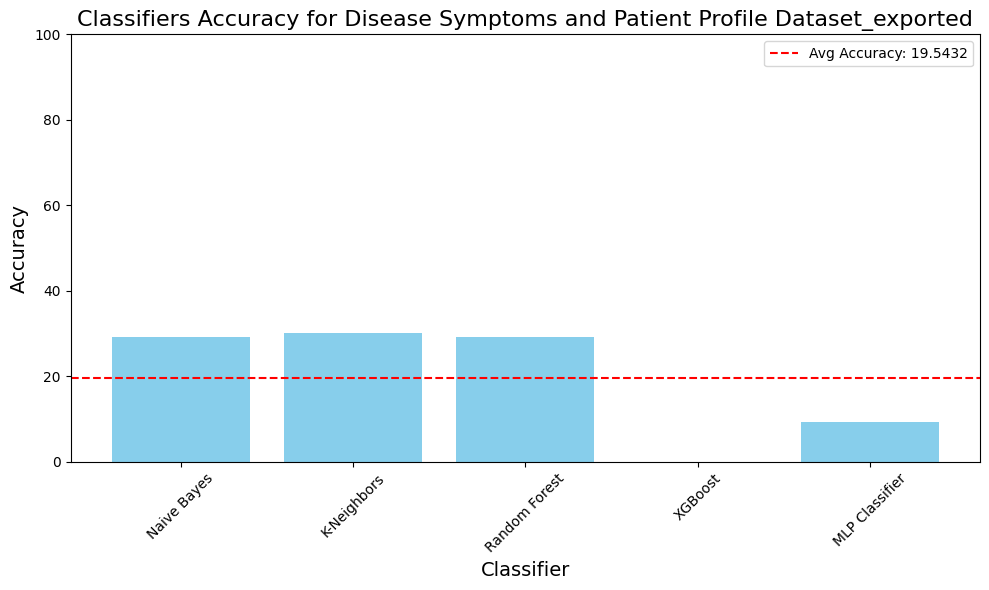

In [96]:
"""
Test dataset on different classifiers to assess performance when predicting the disease. Since the author is predicting multi-class variable needs to be used a `predict_proba()` method to calculate probability of each class (in other words it tells certainty of the prediction.

For binary classification, the `predict()` method is used.
"""

from sklearn.metrics import accuracy_score, log_loss
from sklearn import svm
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

# Define classifiers
classifiers = {
    'Naive Bayes': GaussianNB(),
    'K-Neighbors': KNeighborsClassifier(n_neighbors=7), # tried 3, 5, 7, 10 -> 7 is the best
    'Random Forest': RandomForestClassifier(n_estimators=10, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=5, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    # 'LightGBM': LGBMClassifier(n_estimators=10, random_state=42), # TODO - resolve Warnings
    'MLP Classifier': MLPClassifier(random_state=42, max_iter=1000), # Multi-layer Perceptron
    # 'SVM': svm.SVC() # doesn't support predict_proba
}

results = dict()

# Train and test each classifier
for name, clf in classifiers.items():
    try:
        print(f"\nTraining and testing {name}:")
        
        if name == 'XGBoost':
            loss = train_and_test_xgboost()
        else:
            loss = train_and_test_sklearn_classifier()
            
        print(f"Loss: {loss:.4f}")        
        # Save the results
        results[name] = loss
    except Exception as e:
        print(f"Error: {e}")
        results[name] = 0

visualize_results_performance(results)
